In [455]:
from rich.pretty import pprint


def pretty_print(title: str = None, content: str = None):
    if title is None:
        print(content)
        return
    print(title)
    pprint(content)

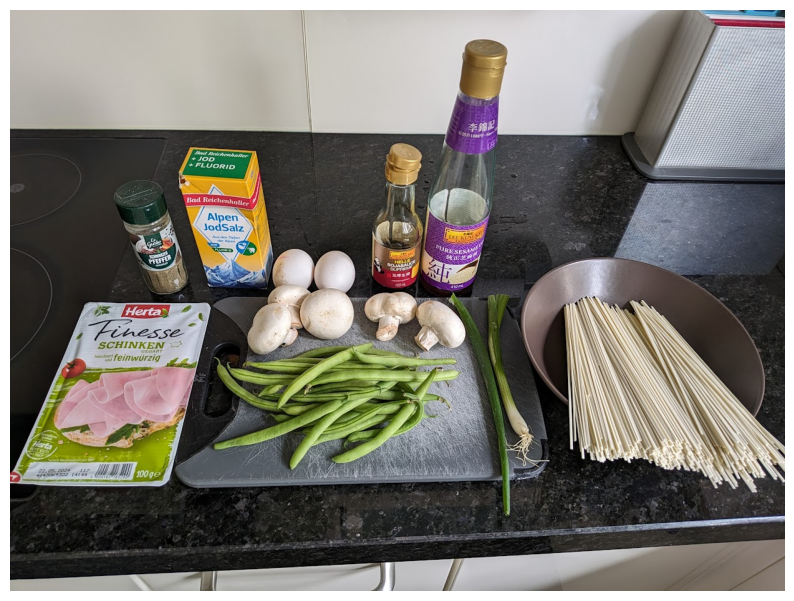

In [456]:
import matplotlib.pyplot as plt

image_path = "tmp/PXL_20240519_091911801.jpg"
import urllib.request

url = "https://dl.dropbox.com/scl/fi/fvpgpwzlqa8v3j6ntis2s/PXL_20240519_091911801.jpg?rlkey=vtc5dakept5jku8klknfaa150"
urllib.request.urlretrieve(url, image_path)

# no axis
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(plt.imread(image_path))

In [457]:
annotated_image_1_path = "tmp/PXL_20240519_091911801_annotated_egg_bean.jpg" 
classes=["bean", "egg"]

## Metrics definition

In [458]:
class Metrics:
    gt: list[str]
    pred: list[str]

    def __init__(self, gt: list[str], pred: list[str]):
        self.gt = set(gt)
        self.pred = set(pred)

        pretty_print("Ground truth", self.gt)
        pretty_print("Prediction", self.pred)

    def accuracy(self) -> float:
        acc = len(self.pred.intersection(self.gt)) / len(self.gt)
        return round(acc, 3)

    @property
    def __str__(self) -> str:
        return f"Accuracy: {self.accuracy()}"

## Yolo8 World

In [459]:
from ultralytics import YOLO
from ultralytics.engine.results import Boxes, Results


def yolo_annotate_image(
    img_path: str, classes: list[str] = list(), model_ckp: str = "yolov8s-world.pt"
) -> tuple[Results, Metrics]:
    """Annotate an image with classes (COCO dataset types)"""
    model = YOLO(model_ckp)  # or select yolov8m/l-world.pt for different sizes

    if len(classes):
        model.set_classes(classes)

    preds = model.predict(img_path)
    results: Results = preds[0]
    cls = results.boxes.cls.cpu().numpy().tolist()
    cls = [int(c) for c in cls]
    label_names = results.names
    selected_names = [label_names[i] for i in cls]
    return results, Metrics(classes, selected_names)


image 1/1 c:\Users\I804028\Desktop\dev\chat-your-doc\tmp\PXL_20240519_091911801.jpg: 480x640 3 eggs, 11.0ms
Speed: 3.0ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)
Ground truth


{'egg', 'bean'}

Prediction


{'egg'}

results


ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'bean', 1: 'egg'}
obb: None
orig_img: array([[[178, 187, 191],
│   │   [178, 187, 191],
│   │   [178, 187, 191],
│   │   ...,
│   │   [ 17,  15,  15],
│   │   [ 14,  13,  15],
│   │   [ 11,  13,  14]],
│      
│      [[178, 187, 191],
│   │   [178, 187, 191],
│   │   [178, 187, 191],
│   │   ...,
│   │   [ 28,  26,  26],
│   │   [ 26,  25,  27],
│   │   [ 25,  27,  28]],
│      
│      [[178, 187, 191],
│   │   [178, 187, 191],
│   │   [178, 187, 191],
│   │   ...,
│   │   [ 21,  21,  21],
│   │   [ 22,  24,  24],
│   │   [ 26,  28,  28]],
│      
│      ...,
│      
│      [[154, 164, 164],
│   │   [155, 165, 165],
│   │   [157, 167, 167],
│   │   ...,
│   │   [114, 123, 136],
│   │   [114, 123, 136],
│   │   [114, 123, 136]],
│      
│      [[154, 164, 164],
│   │   [155, 165, 165],
│   │   [157, 167, 167],
│   │   ...,
│   │   [114, 123, 136],
│   │   [114, 123, 136],
│   │   [114, 123, 136]],
│      
│      [[154, 164, 164],
│   │   [155, 165, 165],
│   │   [157, 167, 167],
│   │   ...,
│   │   [114, 123, 136],
│   │   [114, 123, 136],
│   │   [114, 123, 136]]], dtype=uint8)
orig_shape: (932, 1243)
path: 'c:\\Users\\I804028\\Desktop\\dev\\chat-your-doc\\tmp\\PXL_20240519_091911801.jpg'
probs: None
save_dir: 'runs\\detect\\predict'
speed: {'preprocess': 2.9993057250976562, 'inference': 10.999679565429688, 'postprocess': 2.0003318786621094}

metrics


'Accuracy: 0.5'

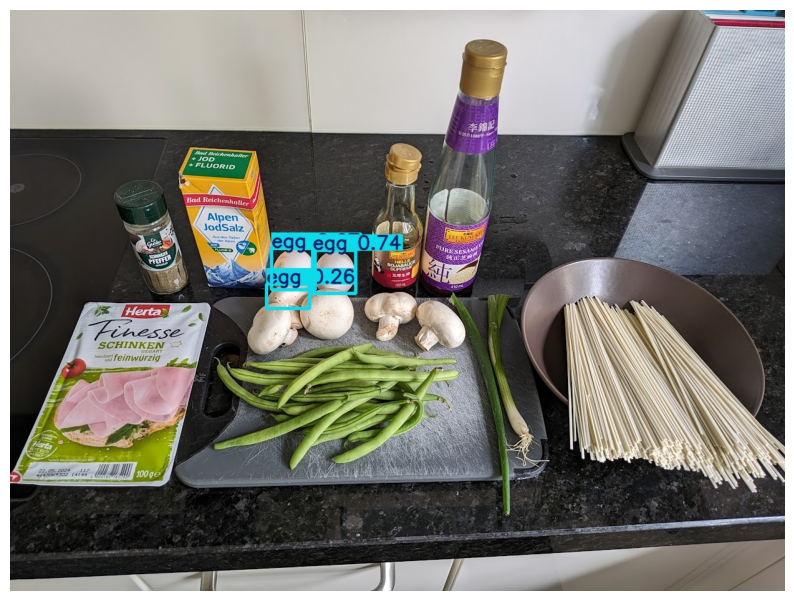

In [460]:
res, metrics = yolo_annotate_image(classes=classes, img_path=image_path)
pretty_print("results", res)
pretty_print("metrics", metrics.__str__)

save_1 = res.save(annotated_image_1_path)
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(plt.imread(annotated_image_1_path))

## GroundingDINO

In [461]:
import torch
from PIL import Image
from transformers import AutoModelForZeroShotObjectDetection, AutoProcessor

import numpy as np
import supervision as sv


def grounding_dino_annotation(
    img_path: str,
    classes: list[str] = None,
    box_threshold: float = 0.32,
    text_threshold: float = 0.32,
):
    image = Image.open(img_path)
    caption = ". ".join(classes) + "." if classes else ""
    model_id = "IDEA-Research/grounding-dino-base"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    processor = AutoProcessor.from_pretrained(model_id)
    model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)
    inputs = processor(images=image, text=caption, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        results = processor.post_process_grounded_object_detection(
            outputs,
            inputs.input_ids,
            box_threshold=box_threshold,
            text_threshold=text_threshold,
            target_sizes=[image.size[::-1]],
        )
        ret = results[0]
        return ret, Metrics(classes, ret["labels"])


def save_groundingDINO(
    transformers_results, classes: list[str], image_path: str, save_path: str = None
):
    res_labels = transformers_results["labels"]

    def class2id(classes: list[str], res_labels: list[str]) -> np.ndarray:
        return np.array([classes.index(label) for label in res_labels])

    confidence = transformers_results["scores"].cpu().detach().numpy()
    detections = sv.Detections(
        xyxy=transformers_results["boxes"].cpu().detach().numpy(),
        confidence=confidence,
        class_id=class2id(classes, res_labels),
    )
    bbox_annotator, label_annotator = sv.BoundingBoxAnnotator(
        color=sv.ColorPalette.ROBOFLOW
    ), sv.LabelAnnotator(color=sv.ColorPalette.ROBOFLOW)
    annotated_image = label_annotator.annotate(
        bbox_annotator.annotate(
            Image.open(image_path),
            detections=detections,
            custom_color_lookup=sv.ColorLookup.CLASS,
        ),
        detections=detections,
        labels=[
            label + " " + str(round(score, 2))
            for label, score in zip(res_labels, confidence)
        ],
        custom_color_lookup=sv.ColorLookup.CLASS,
    )
    if save_path is not None:
        annotated_image.save(save_path)
    else:
        sv.plot_image(image=annotated_image)

Ground truth


{'egg', 'bean'}

Prediction


{'bean', 'egg'}

transformers_results


{
│   'scores': tensor([0.5621, 0.5461, 0.5855], device='cuda:0'),
│   'labels': ['egg', 'egg', 'bean'],
│   'boxes': tensor([[487.8397, 385.8007, 554.0634, 453.2173],
│   │   [420.0773, 383.0943, 488.2356, 447.6725],
│   │   [327.7066, 532.7361, 720.4658, 737.7151]], device='cuda:0')
}

metrics


1.0

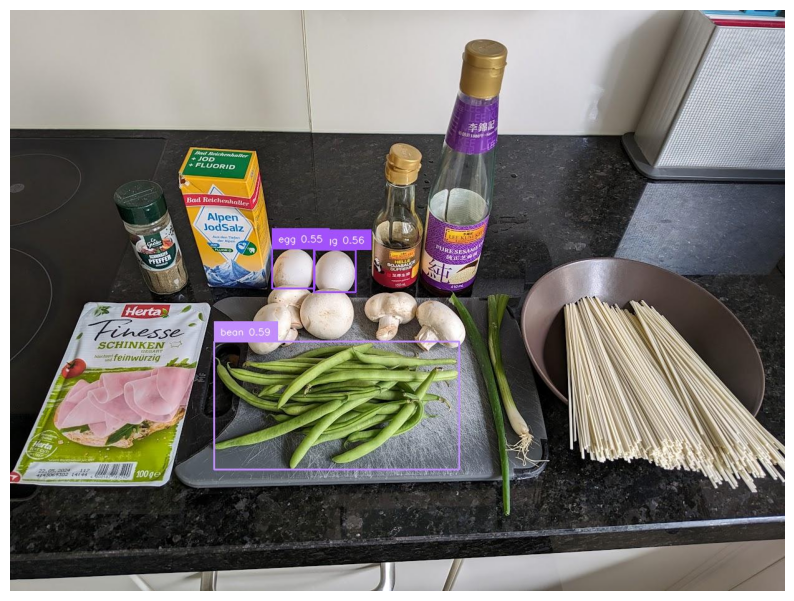

In [443]:
transformers_results, metrics = grounding_dino_annotation(
    img_path=image_path, classes=classes
)
pretty_print("transformers_results", transformers_results)
pretty_print("metrics", metrics.accuracy())

save_groundingDINO(transformers_results, classes, image_path, annotated_image_1_path)
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(plt.imread(annotated_image_1_path))

In [444]:
## Florence 2

# from transformers import AutoModelForCausalLM, AutoProcessor

# def florence2_annotation(img_path: str, classes: list[str]):
#     prompt = ",".join(classes)
#     image = Image.open(img_path)
#     model = AutoModelForCausalLM.from_pretrained(
#         "microsoft/Florence-2-base", trust_remote_code=True
#     )
#     processor = AutoProcessor.from_pretrained(
#         "microsoft/Florence-2-base", trust_remote_code=True
#     )
#     inputs = processor(text=prompt, images=image, return_tensors="pt")
#     generated_ids = model.generate(
#         input_ids=inputs["input_ids"],
#         pixel_values=inputs["pixel_values"],
#         max_new_tokens=1024,
#         do_sample=False,
#         num_beams=3,
#     )
#     generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
#     results = processor.post_process_generation(
#         generated_text, task="<OD>", image_size=(image.width, image.height)
#     )
#     return results[0], image

In [445]:
# transformers_results, model = florence2_annotation(
#     img_path=image_path, classes=classes
# )
# pretty_print("transformers_results", transformers_results)

## Multi-modal LLM for image description

In [446]:
import base64
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage


def image_detector(image_path: str, temperature: float = 0.0) -> str:
    """Detects objects in an image as much as possible and returns the description of the image."""
    with open(image_path, "rb") as image_file:
        base64_image = base64.b64encode(image_file.read()).decode("utf-8")
        # pretty_print("base64_image", base64_image)

        chat = ChatOpenAI(model="gpt-4o", temperature=temperature, max_tokens=1024 * 2)
        res = chat.invoke(
            [
                HumanMessage(
                    content=[
                        {"type": "text", "text": "What is this image showing"},
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{base64_image}",
                            },
                        },
                    ]
                )
            ]
        )

        return res.content

In [447]:
image_description = image_detector(image_path)
pretty_print("image_description", image_description)

image_description


'The image shows a kitchen countertop with various ingredients and cooking items laid out, likely in preparation for cooking a meal. The items include:\n\n- A package of sliced ham (Herta Finesse Schinken)\n- A container of ground black pepper\n- A box of iodized salt (Alpen JodSalz)\n- Three eggs\n- Several white mushrooms\n- A bunch of green beans\n- A green onion (scallion)\n- A bottle of soy sauce\n- A bottle of pure sesame oil\n- A bowl containing uncooked noodles\n\nThese ingredients suggest that the meal being prepared might be an Asian-inspired dish, possibly a noodle stir-fry or similar recipe.'

In [448]:
from langchain.prompts.chat import ChatPromptTemplate

def coco_label_extractor(img_desc: str) -> str:
    """Read an image description and extract COCO defined labels as much as possible from the description."""
    chat_template = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """You as an AI assistant can understand an image descritpion. 
                 Try to extract COCO defined labels as much as possible from the description.
                 Only return lables and split by comma, no empty space between labels.""",
            ),
            ("human", "Image descritpion: {img_desc}"),
        ]
    )
    human_input = chat_template.format_messages(img_desc=img_desc)
    chat = ChatOpenAI(model="gpt-3.5-turbo", temperature=0, max_tokens=1024)
    return chat.invoke(human_input).content

## To COCO labels

In [449]:
coco_labels = coco_label_extractor(image_description)
pretty_print("coco_labels", coco_labels)

coco_label_list = coco_labels.split(",")
coco_label_list = [label.strip() for label in coco_label_list]
pretty_print("coco_label_list", coco_label_list)

coco_labels


'food, bottle, bowl, egg, mushroom, onion, pepper, salt, ham, bean, noodle, soy sauce, sesame oil'

coco_label_list


[
│   'food',
│   'bottle',
│   'bowl',
│   'egg',
│   'mushroom',
│   'onion',
│   'pepper',
│   'salt',
│   'ham',
│   'bean',
│   'noodle',
│   'soy sauce',
│   'sesame oil'
]

In [450]:
class concated_image_result:
    res_img_path: str
    title: str
    description: str

    def __init__(self, res_img_path: str, title: str, description: str):
        self.res_img_path = res_img_path
        self.title = title
        self.description = description

concated_image_results = list[concated_image_result]()

def show_concated_image(concated_image_results: list[concated_image_result]):
    plt.figure(figsize=(20, 10))
    for i, res in enumerate(concated_image_results):
        axs = plt.subplot(1, len(concated_image_results), i + 1)
        axs.set_title(res.title)
        axs.axis("off")
        axs.text(
            0,
            -20,
            res.description,
            verticalalignment="top",
            horizontalalignment="left",
            fontsize=12,
            color="red",
        )

        plt.imshow(plt.imread(res.res_img_path))

### COCO on Yolo8 World


image 1/1 c:\Users\I804028\Desktop\dev\chat-your-doc\tmp\PXL_20240519_091911801.jpg: 480x640 3 bottles, 1 bowl, 3 eggs, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
Ground truth


{
│   'bowl',
│   'mushroom',
│   'bottle',
│   'salt',
│   'noodle',
│   'food',
│   'egg',
│   'ham',
│   'soy sauce',
│   'sesame oil',
│   'bean',
│   'pepper',
│   'onion'
}

Prediction


{'bowl', 'egg', 'bottle'}

res


ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'food', 1: 'bottle', 2: 'bowl', 3: 'egg', 4: 'mushroom', 5: 'onion', 6: 'pepper', 7: 'salt', 8: 'ham', 9: 'bean', 10: 'noodle', 11: 'soy sauce', 12: 'sesame oil'}
obb: None
orig_img: array([[[178, 187, 191],
│   │   [178, 187, 191],
│   │   [178, 187, 191],
│   │   ...,
│   │   [ 17,  15,  15],
│   │   [ 14,  13,  15],
│   │   [ 11,  13,  14]],
│      
│      [[178, 187, 191],
│   │   [178, 187, 191],
│   │   [178, 187, 191],
│   │   ...,
│   │   [ 28,  26,  26],
│   │   [ 26,  25,  27],
│   │   [ 25,  27,  28]],
│      
│      [[178, 187, 191],
│   │   [178, 187, 191],
│   │   [178, 187, 191],
│   │   ...,
│   │   [ 21,  21,  21],
│   │   [ 22,  24,  24],
│   │   [ 26,  28,  28]],
│      
│      ...,
│      
│      [[154, 164, 164],
│   │   [155, 165, 165],
│   │   [157, 167, 167],
│   │   ...,
│   │   [114, 123, 136],
│   │   [114, 123, 136],
│   │   [114, 123, 136]],
│      
│      [[154, 164, 164],
│   │   [155, 165, 165],
│   │   [157, 167, 167],
│   │   ...,
│   │   [114, 123, 136],
│   │   [114, 123, 136],
│   │   [114, 123, 136]],
│      
│      [[154, 164, 164],
│   │   [155, 165, 165],
│   │   [157, 167, 167],
│   │   ...,
│   │   [114, 123, 136],
│   │   [114, 123, 136],
│   │   [114, 123, 136]]], dtype=uint8)
orig_shape: (932, 1243)
path: 'c:\\Users\\I804028\\Desktop\\dev\\chat-your-doc\\tmp\\PXL_20240519_091911801.jpg'
probs: None
save_dir: 'runs\\detect\\predict'
speed: {'preprocess': 0.9999275207519531, 'inference': 9.998321533203125, 'postprocess': 1.001596450805664}

bbox


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1., 1., 3., 3., 1., 2., 3.], device='cuda:0')
conf: tensor([0.8965, 0.8569, 0.7855, 0.6976, 0.6867, 0.5823, 0.3257], device='cuda:0')
data: tensor([[6.5533e+02, 4.7231e+01, 8.0000e+02, 4.6063e+02, 8.9649e-01, 1.0000e+00],
│   │   [5.8077e+02, 2.1402e+02, 6.6194e+02, 4.5105e+02, 8.5686e-01, 1.0000e+00],
│   │   [4.8620e+02, 3.8646e+02, 5.5424e+02, 4.5438e+02, 7.8547e-01, 3.0000e+00],
│   │   [4.1952e+02, 3.8336e+02, 4.8854e+02, 4.4860e+02, 6.9762e-01, 3.0000e+00],
│   │   [1.6430e+02, 2.7226e+02, 2.8762e+02, 4.5959e+02, 6.8665e-01, 1.0000e+00],
│   │   [8.1580e+02, 3.9757e+02, 1.2140e+03, 6.5242e+02, 5.8225e-01, 2.0000e+00],
│   │   [4.1214e+02, 4.4048e+02, 4.8054e+02, 4.7843e+02, 3.2572e-01, 3.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (932, 1243)
shape: torch.Size([7, 6])
xywh: tensor([[ 727.6643,  253.9317,  144.6759,  413.4011],
│   │   [ 621.3566,  332.5360,   81.1679,  237.0289],
│   │   [ 520.2197,  420.4174,   68.0365,   67.9154],
│   │   [ 454.0295,  415.9777,   69.0144,   65.2440],
│   │   [ 225.9560,  365.9254,  123.3203,  187.3330],
│   │   [1014.8762,  524.9914,  398.1553,  254.8493],
│   │   [ 446.3389,  459.4562,   68.4008,   37.9559]], device='cuda:0')
xywhn: tensor([[0.5854, 0.2725, 0.1164, 0.4436],
│   │   [0.4999, 0.3568, 0.0653, 0.2543],
│   │   [0.4185, 0.4511, 0.0547, 0.0729],
│   │   [0.3653, 0.4463, 0.0555, 0.0700],
│   │   [0.1818, 0.3926, 0.0992, 0.2010],
│   │   [0.8165, 0.5633, 0.3203, 0.2734],
│   │   [0.3591, 0.4930, 0.0550, 0.0407]], device='cuda:0')
xyxy: tensor([[ 655.3264,   47.2312,  800.0023,  460.6323],
│   │   [ 580.7726,  214.0216,  661.9406,  451.0505],
│   │   [ 486.2014,  386.4597,  554.2379,  454.3751],
│   │   [ 419.5223,  383.3556,  488.5367,  448.5997],
│   │   [ 164.2958,  272.2589,  287.6162,  459.5919],
│   │   [ 815.7985,  397.5667, 1213.9539,  652.4161],
│   │   [ 412.1385,  440.4783,  480.5393,  478.4342]], device='cuda:0')
xyxyn: tensor([[0.5272, 0.0507, 0.6436, 0.4942],
│   │   [0.4672, 0.2296, 0.5325, 0.4840],
│   │   [0.3912, 0.4147, 0.4459, 0.4875],
│   │   [0.3375, 0.4113, 0.3930, 0.4813],
│   │   [0.1322, 0.2921, 0.2314, 0.4931],
│   │   [0.6563, 0.4266, 0.9766, 0.7000],
│   │   [0.3316, 0.4726, 0.3866, 0.5133]], device='cuda:0')

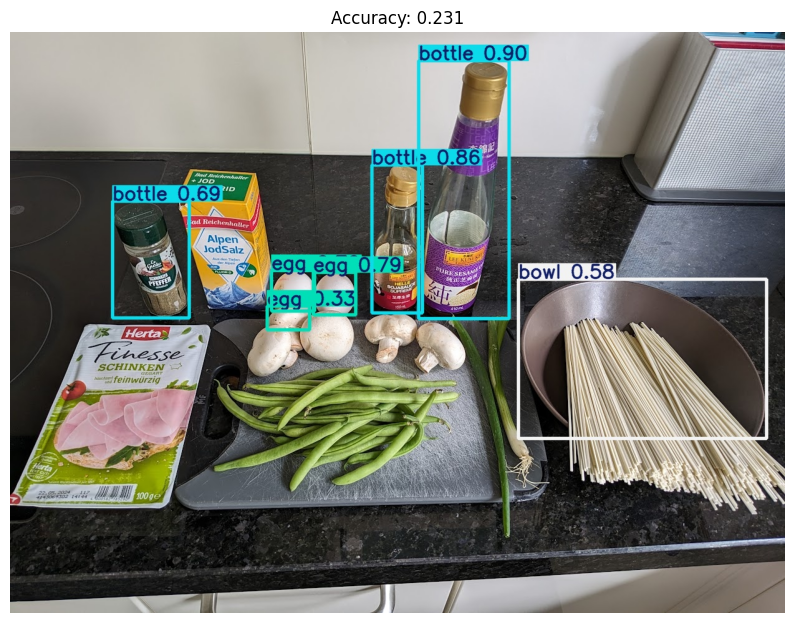

In [451]:
yolo8world_final_path = "tmp/yolo8world_final_annotated.jpg"
res, metrics = yolo_annotate_image(classes=coco_label_list, img_path=image_path)
pretty_print("res", res)
pretty_print("bbox", res.boxes)
concated_image_results.append(
    concated_image_result(
        yolo8world_final_path, "YOLO8World + GPT ochstrated", metrics.__str__
    )
)

save_1 = res.save(yolo8world_final_path)
plt.figure(figsize=(10, 10))
plt.axis("off") 
plt.title(metrics.__str__)
plt.imshow(plt.imread(yolo8world_final_path))

### Free of labels on Yolo8 World (self)


image 1/1 c:\Users\I804028\Desktop\dev\chat-your-doc\tmp\PXL_20240519_091911801.jpg: 480x640 3 bottles, 1 bowl, 1 banana, 1 dining table, 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)
Ground truth


set()

Prediction


{'bowl', 'dining table', 'bottle', 'banana'}

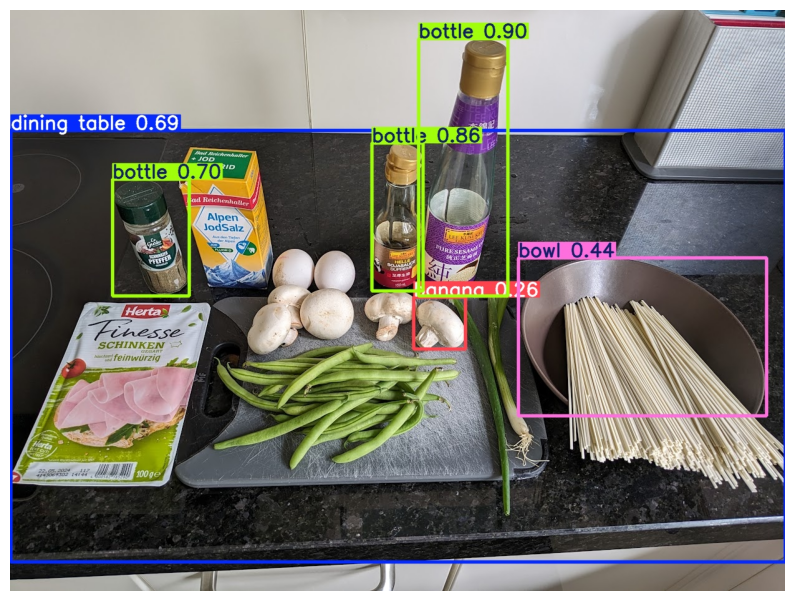

In [452]:
yolo8world_self_final_path = "tmp/yolo8world_final_self_annotated.jpg"
res, _ = yolo_annotate_image(img_path=image_path) 
concated_image_results.append(
    concated_image_result(
        yolo8world_self_final_path, "YOLO8World Self, no LLM ochstrated", ""
    )
)
save_1 = res.save(yolo8world_self_final_path)
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(plt.imread(yolo8world_self_final_path))

### COCO on GroundingDINO

Ground truth


{
│   'bowl',
│   'mushroom',
│   'bottle',
│   'salt',
│   'noodle',
│   'food',
│   'egg',
│   'ham',
│   'soy sauce',
│   'sesame oil',
│   'bean',
│   'pepper',
│   'onion'
}

Prediction


{'bowl', 'mushroom', 'bottle', 'food', 'egg', 'sesame oil', 'bean'}

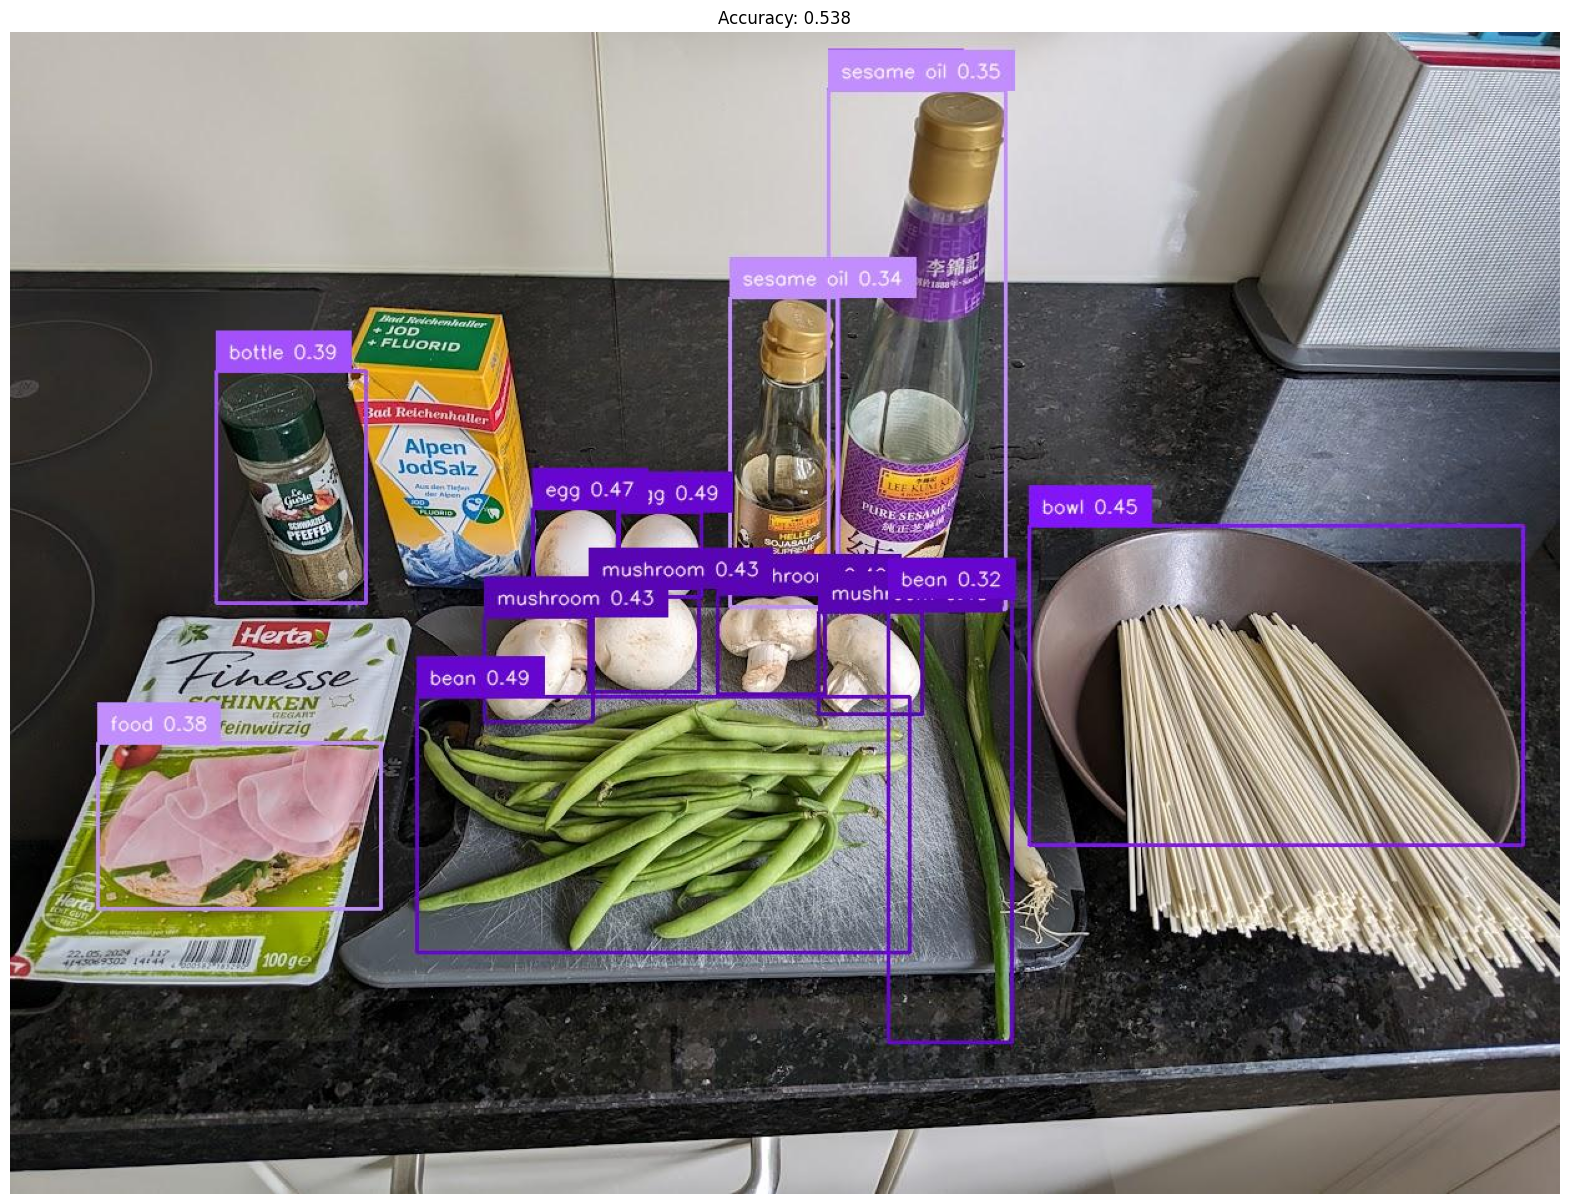

In [453]:
groundingDINO_final_path = "tmp/groundingDINO_final_annotated.jpg"
transformers_results, metrics = grounding_dino_annotation(
    img_path=image_path, classes=coco_label_list
)
concated_image_results.append(
    concated_image_result(
        groundingDINO_final_path, "GroundingDINO + GPT ochstrated", metrics.__str__
    )
)
save_groundingDINO(transformers_results, coco_label_list, image_path, groundingDINO_final_path)
plt.figure(figsize=(20, 20))
plt.axis("off")
plt.title(metrics.__str__)
plt.imshow(plt.imread(groundingDINO_final_path))

## Show results on row

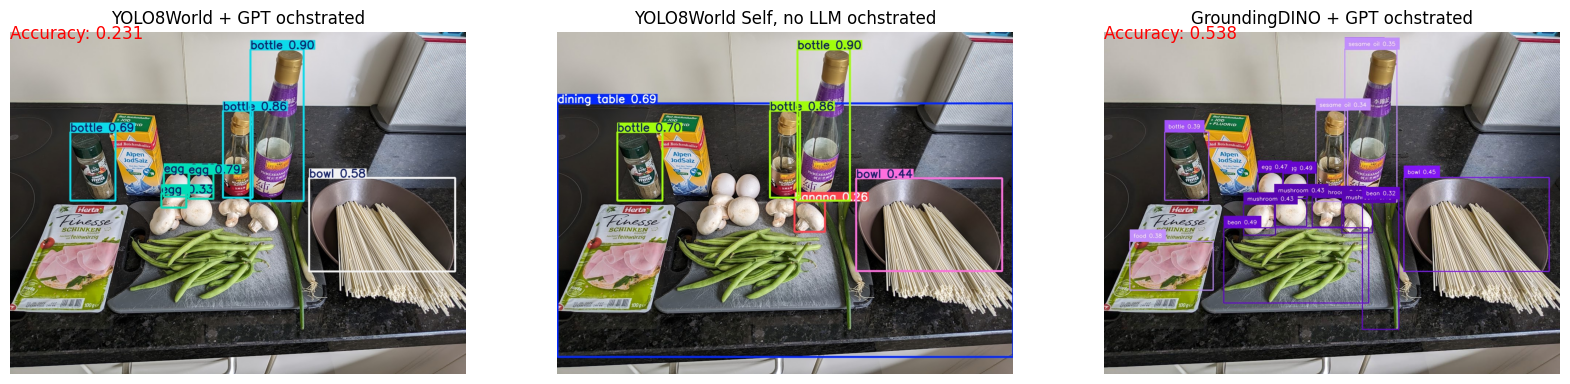

In [454]:
show_concated_image(concated_image_results)